# Predicting the Programming Languages of the Most Starred Github Repos
**by Daniel Guerrero and Yvonne King**

**Quick Notebook Reference**

1. Project Plan
2. Imports
3. Acquire
4. Prep
5. Exploration
6. Models
7. Model Evaluation
8. Final Conclusions

## Project Plan

**Acquisition, Prep, and Initial Exploration**
- Fetch Data from local cache
- Handle Missing Values
- Remove/repair erroneous data
- Look at shape of data
- normalize data by removing non ASCII characters
- tokenize words
- stem and lemmatize words
- remove stop words

**Exploration**

- Answer the following questions:
    - What are the most common words in READMEs?
    - What does the distribution of IDFs look like for the most common words?
    - Does the length of the README vary by programming language?
    - Do different programming languages use a different number of unique words?
    
**Modeling**
- Build a model that can predict what programming language a repository is, based on the text of the README file

### Main Hypothesis:

Given that we are asked to predict the type of programming language being used, based on the contents of the README, we think that the following strategies will help us be successful.

1. Hopefully, the majority of the README's will actually mention the programming language used, which can help the model better predict the target variable. 
1. Hopefully, there will also be a distinction in the length of the README's, as ceirtain programming languages are know to be more verbose than others, and the community that uses these languages usually mirors that. We will look to see if this is represented in that data, and is something that can be used for modeling.
1. Given the large number of programming languages available, it might be better to actually group some of the languages together, so that we can reduce the number of target variables. 

**Hypothesis**

Given the scale of the corpus, we predict that the TF-IDF will help us identify those words that appear most in a document, and give us an indication of how unique those words are among the different documents, helping the model more easily identify what key words are important when classifying individual documents. 

* $H_0$: The TF-IDF will not be the best feature for modeling.  
* $H_a$: The TF-IDF will be the best feature for modeling.  




## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import re

from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd
from scipy import stats


import seaborn as sns
import matplotlib.pyplot as plt


import nltk
import nltk.sentiment
# from wordcloud import WordCloud

import acquire
import prepare
import explore
import model

## Acquire
- We ran the acquire.py file in command line to generate the json file that we used to save on computing time
    - This file has functions that scrape Githup repos and pull in the readme file contents along with the programming language of the repo
- Fetched data from local cache

In [2]:
#read in data
df = pd.read_json("data.json")

In [3]:
#take a look at the shape of our data
df.shape

(384, 3)

In [4]:
#check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 3 columns):
repo               384 non-null object
language           333 non-null object
readme_contents    382 non-null object
dtypes: object(3)
memory usage: 9.1+ KB


In [5]:
#look at dataframe structure
df.head(5)

,repo,language,readme_contents
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...
1,996icu/996.ICU,Rust,[996.ICU](https://996.icu/#/en_US)\n=======\n*...
2,vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ..."
3,EbookFoundation/free-programming-books,None,This page is available as an easy-to-read webs...
4,facebook/react,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...


## Prep
Using the prep_readme_function we will:
- normalize data by removing non ASCII characters
- tokenize words
- lemmatize words
- remove stop words

In [6]:
#function to prepare our data for modeling
df = prepare.prep_readme_data(df)

In [7]:
df.describe()

,repo,language,readme_contents,clean_tokes,clean_lemmatized
count,384,333,382,384,384
unique,384,30,382,383,383
top,twbs/bootstrap,JavaScript,Metasploit [![Build Status](https://travis-ci....,[None],None
freq,1,103,1,2,2


In [8]:
#look at dataframe structure
df.head(5)

,repo,language,readme_contents,clean_tokes,clean_lemmatized
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,"[freecodecamporg, social, bannerhttpss3amazona...",freecodecamporg social bannerhttpss3amazonawsc...
1,996icu/996.ICU,Rust,[996.ICU](https://996.icu/#/en_US)\n=======\n*...,"[996icuhttps996icuen_us, please, note, that, t...",996icuhttps996icuen_us please note exists offi...
2,vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ...","[p, aligncentera, hrefhttpsvuejsorg, target_bl...",p aligncentera hrefhttpsvuejsorg target_blank ...
3,EbookFoundation/free-programming-books,None,This page is available as an easy-to-read webs...,"[this, page, is, available, as, an, easytoread...",page available easytoread website httpsebookfo...
4,facebook/react,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...,"[reacthttpsreactjsorg, middot, github, license...",reacthttpsreactjsorg middot github licensehttp...


In [9]:
#Take a look at languages
df.language.value_counts(dropna=False)

JavaScript          103
NaN                  51
Python               43
Go                   26
Java                 25
C++                  20
TypeScript           19
Shell                12
CSS                  11
Ruby                 11
HTML                  9
Swift                 9
C                     8
PHP                   7
Jupyter Notebook      5
Dart                  3
Rust                  3
Vue                   3
TeX                   2
Kotlin                2
Objective-C           2
Scala                 1
Julia                 1
Lua                   1
Dockerfile            1
OCaml                 1
Emacs Lisp            1
Clojure               1
C#                    1
Haskell               1
Vim script            1
Name: language, dtype: int64

- There are a few missing rows that are missing the programming language so will drop this columns by using the prepare_data function from prepare.py
- ALso based on the first glance of the language distrobutions we have decided to go with the more poplular languages JavaScript, Python, Java, C++ and have combined all other languages into a new variable other

In [10]:
df.readme_contents = df.readme_contents.dropna()

In [11]:
#drop na and create is_top_language column
df = prepare.prepare_data(df)

In [12]:
#peek at the datafram
df.head(5)

,repo,language,readme_contents,clean_tokes,clean_lemmatized,is_top_language
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,"[freecodecamporg, social, bannerhttpss3amazona...",freecodecamporg social bannerhttpss3amazonawsc...,JavaScript
1,996icu/996.ICU,Rust,[996.ICU](https://996.icu/#/en_US)\n=======\n*...,"[996icuhttps996icuen_us, please, note, that, t...",996icuhttps996icuen_us please note exists offi...,other
4,facebook/react,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...,"[reacthttpsreactjsorg, middot, github, license...",reacthttpsreactjsorg middot github licensehttp...,JavaScript
16,airbnb/javascript,JavaScript,# Airbnb JavaScript Style Guide() {\n\n*A most...,"[airbnb, javascript, style, guide, a, mostly, ...",airbnb javascript style guide mostly reasonabl...,JavaScript
17,flutter/flutter,Dart,# [![Flutter logo][]][flutter.dev]\n\n[![Build...,"[flutter, logoflutterdev, build, status, cirru...",flutter logoflutterdev build status cirrusbuil...,other


In [13]:
#Take a look at languages again using our new column
df.is_top_language.value_counts(dropna=False)

other         110
JavaScript     59
Python         28
Java           22
C++            17
Name: is_top_language, dtype: int64

## Exploration

### Distribution of Data
- Here we looked at the distribution of data so we could get a feel for the data

In [14]:
# Quick dataframe to view the distribution of all languages
pd.concat(
    [df.language.value_counts(), df.language.value_counts(normalize=True)], axis=1
    ).set_axis(['n', 'percent'], axis=1, inplace=False)

,n,percent
JavaScript,59,0.250000
Python,28,0.118644
Go,24,0.101695
Java,22,0.093220
C++,17,0.072034
TypeScript,11,0.046610
Ruby,11,0.046610
CSS,10,0.042373
C,8,0.033898
Shell,8,0.033898


In [15]:
# Quick dataframe to view the distribution of our top languages
pd.concat(
    [df.is_top_language.value_counts(), df.is_top_language.value_counts(normalize=True)], axis=1
    ).set_axis(['n', 'percent'], axis=1, inplace=False)

,n,percent
other,110,0.466102
JavaScript,59,0.250000
Python,28,0.118644
Java,22,0.093220
C++,17,0.072034


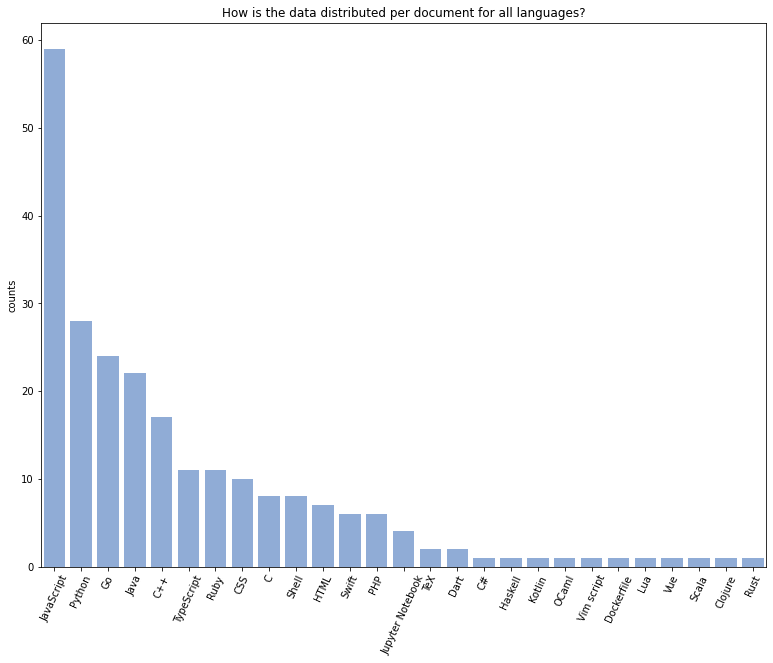

In [16]:
#plot the distros for all languages
explore.plot_distro_for_value_counts_all(df)

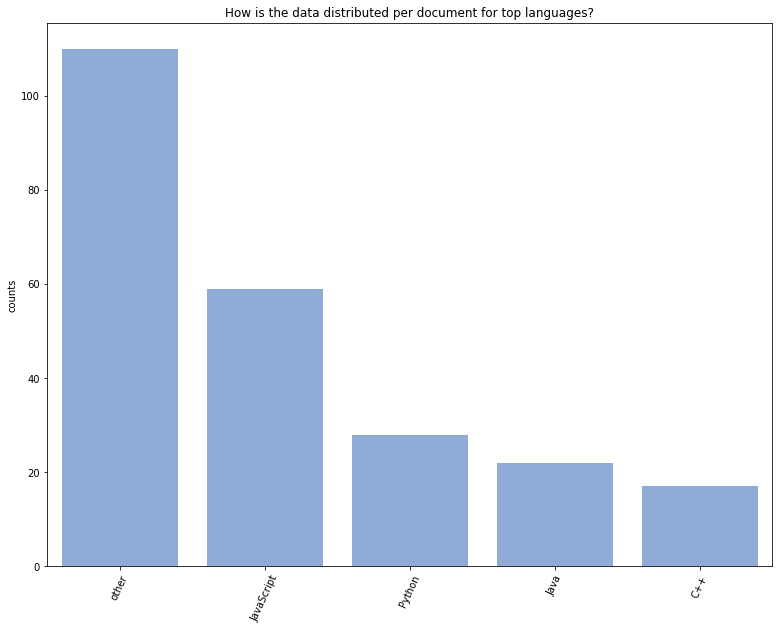

In [17]:
#plot the distros for top languages
explore.plot_distro_for_value_counts_top(df)

### REAMDE lengths by language

**Question Asked:** 

Does the length of the README vary by programming language?

**Answers** 
- It looks like most readmes have under 25k characters
- Pyhton and Swift seem to have a few outliers
- Overall the length of the readme's seem to be relatively similar

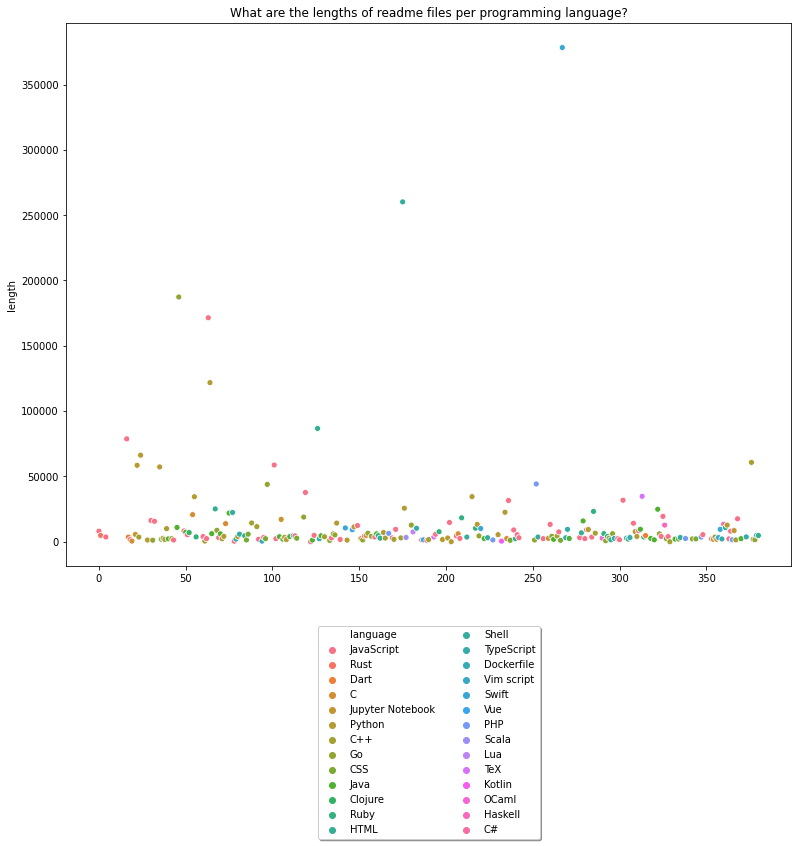

In [18]:
#scatterplot visual of the various readmes lengths hued language
explore.scatterplot_for_readmes(df)

#### Lets take a look at the medians, min, and max

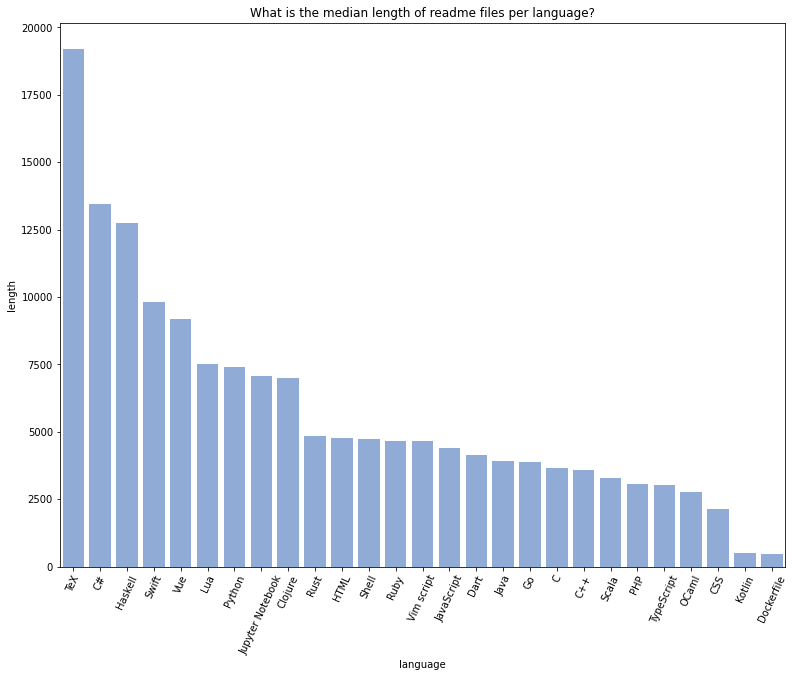

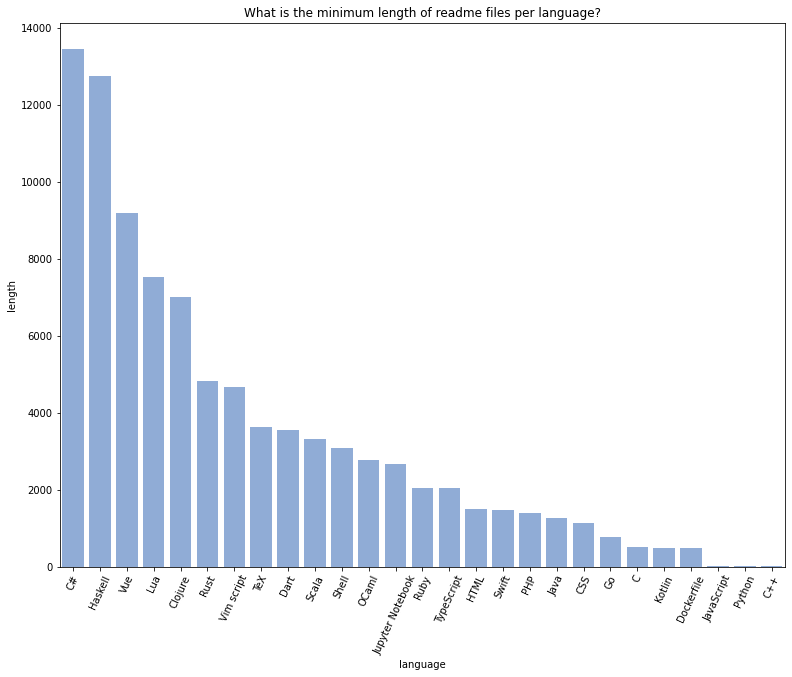

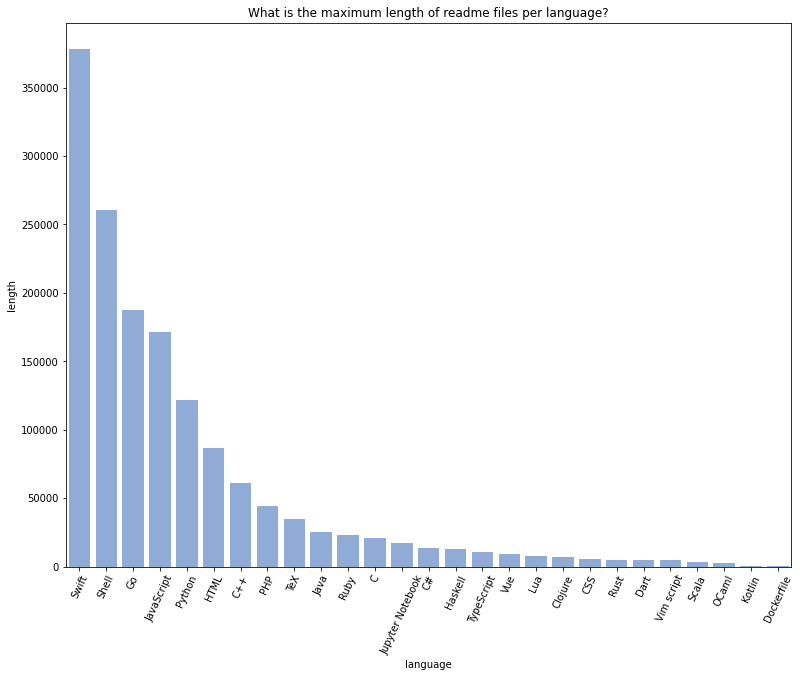

In [19]:
#function to plot the lengths o the readmes for all the languages
explore.bargraphs_for_min_max_median(df)

In [20]:
#Quick dataframe of the top programming languages
explore.word_count_summary(df)

,Min Word Count,Max Word Count,Median Word Count,Mean Word Count,STD of Word Count
is_top_language,,,,,
C++,2,6141,284.0,724.823529,1446.395573
Java,74,2257,260.0,416.181818,471.725065
JavaScript,1,15587,405.0,1058.542373,2282.209428
Python,1,10258,820.5,1884.892857,2522.505828
other,55,27171,361.5,1280.227273,3709.168924


### Unique Words

**Question:**

Do different programming languages use a different number of unique words?

**Answer:**
- The other programming languages have more unique words but this is most likely due the fact that we combined languages
- Python seems to have the greatest number of unique words

In [21]:
#use function to create a list of all words for top languages
javascript_words, python_words, java_words, cpp_words, other_words, all_words = explore.list_of_words_for_top_languages(df, language="is_top_language", cleaned="clean_lemmatized")

In [22]:
#print out the unique number of words per language
js_nunique = pd.Series(javascript_words).nunique()
py_nunique = pd.Series(python_words).nunique()
java_nunique = pd.Series(java_words).nunique()
cpp_nunique = pd.Series(cpp_words).nunique()
other_nunique = pd.Series(other_words).nunique()

print(f"Java Svript readmes have {js_nunique:,} unique words")
print(f"Pyhton readmes have {py_nunique:,} unique words")
print(f"Java readmes have {java_nunique:,} unique words")
print(f"C++ readmes have {cpp_nunique:,} unique words")
print(f"The other programming languages have {other_nunique:,} unique words in their readmes")

Java Svript readmes have 16,527 unique words
Pyhton readmes have 12,561 unique words
Java readmes have 3,960 unique words
C++ readmes have 4,184 unique words
The other programming languages have 27,773 unique words in their readmes


### Bigrams

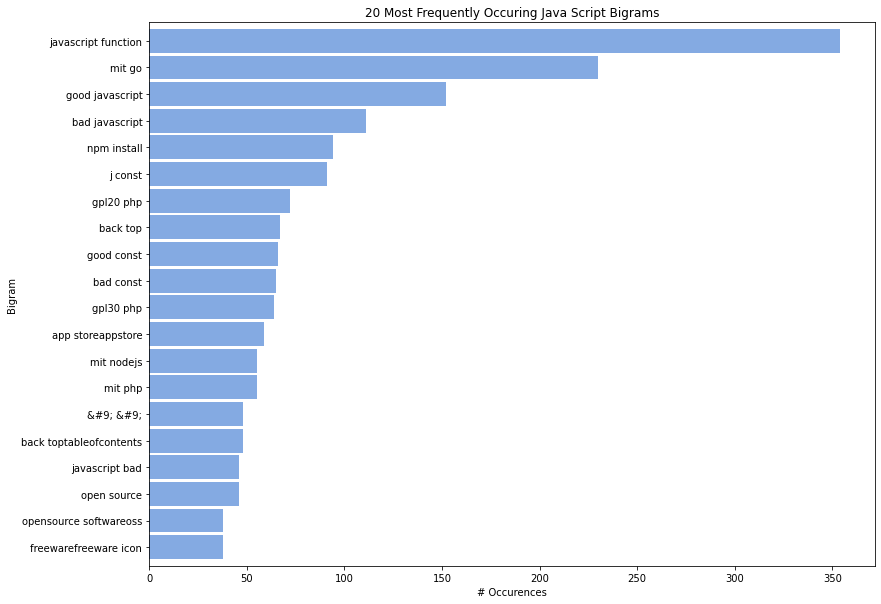

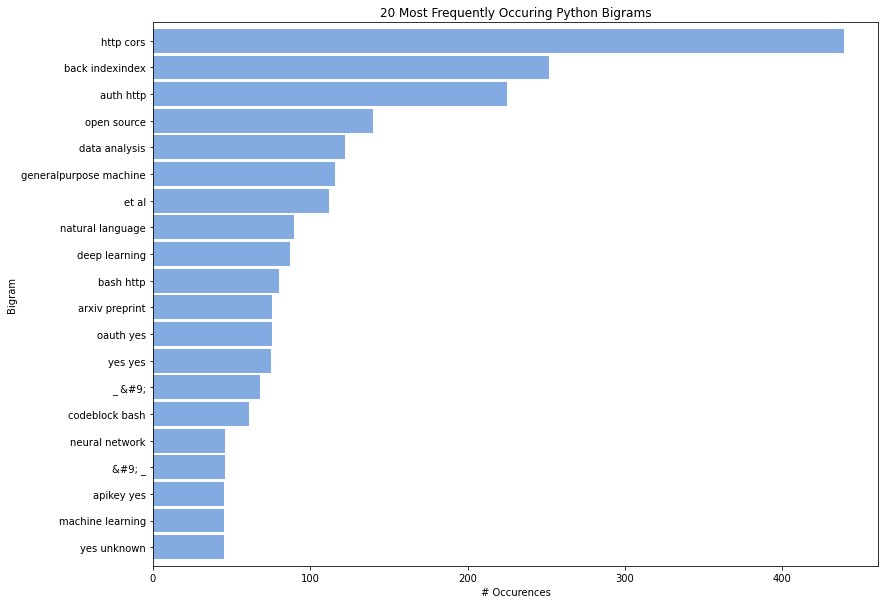

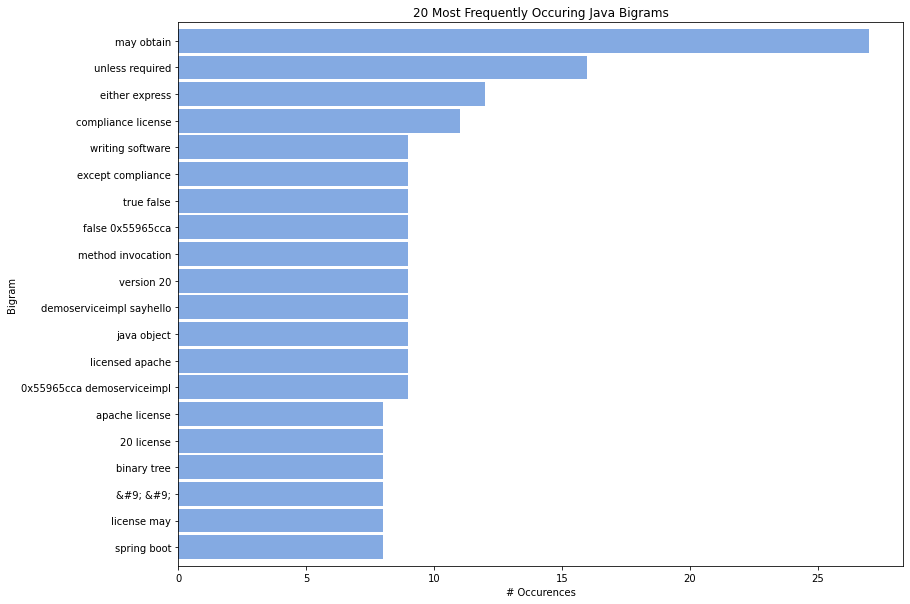

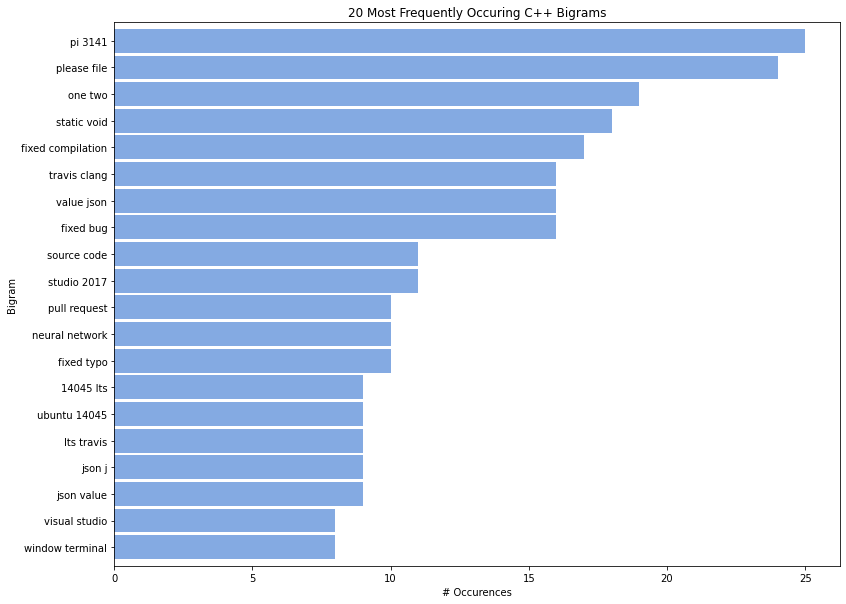

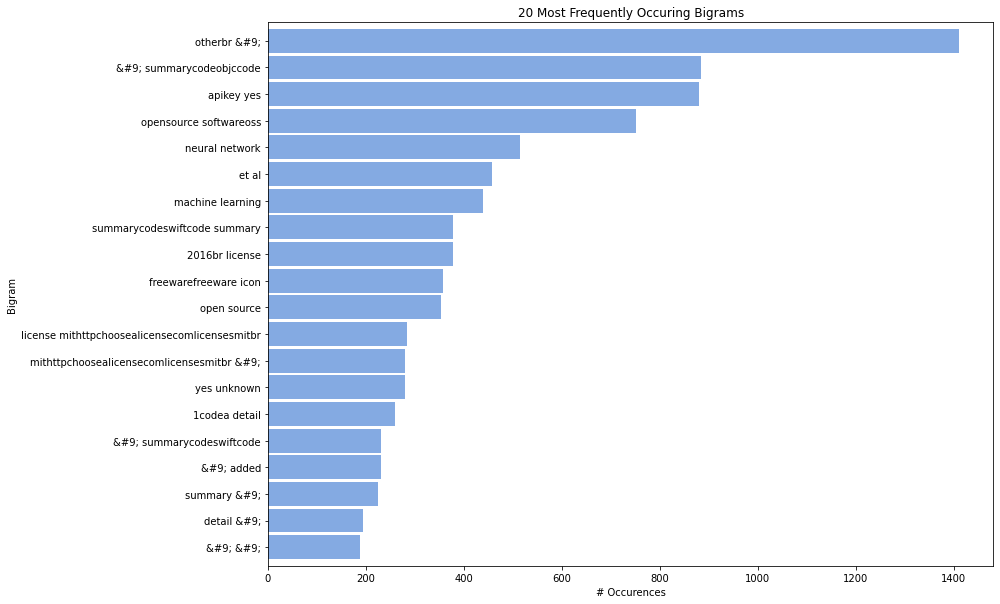

In [23]:
#plot the bigrams for top languages
explore.plot_bigrams(df)

In [24]:
#create list of top 20 bugrams for each variable in top languages
top_20_bigrams, top_20_js_bigrams, top_20_p_bigrams, top_20_j_bigrams, top_20_cpp_bigrams, top_20_other_bigrams = explore.create_bigrams(df)

### Word Clouds

In [25]:
# #Java Script word cloud
# explore.word_cloud(javascript_words)

In [26]:
# #Pyhton word cloud
# explore.word_cloud(python_words)

In [27]:
# #Java word cloud
# explore.word_cloud(java_words)

In [28]:
# #C++ word cloud
# explore.word_cloud(cpp_words)

## What are the most common words in READMEs?

In [29]:
df.groupby("is_top_language").clean_lemmatized.agg(["count", explore.most_frequent_word])

,count,most_frequent_word
is_top_language,,
C++,17,json
Java,22,java
JavaScript,59,source
Python,28,python
other,110,9


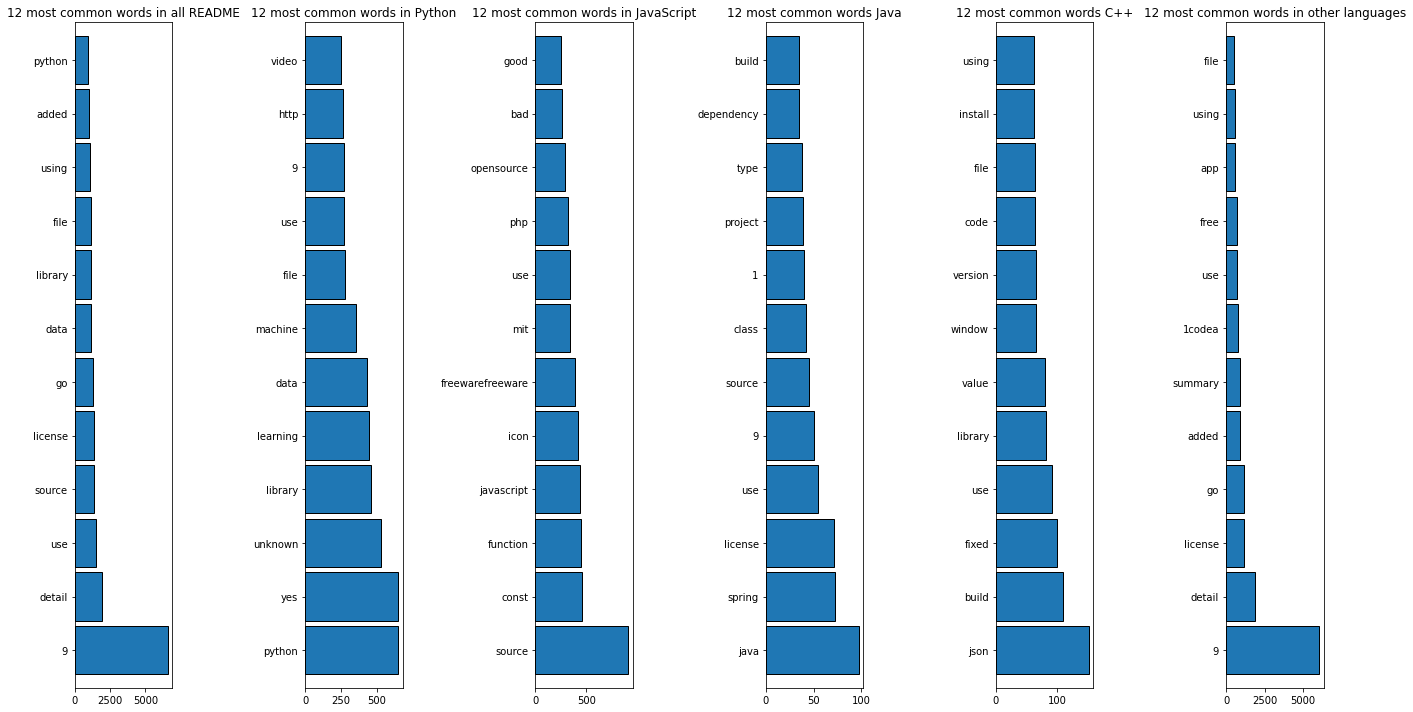

In [30]:
explore.most_common_words(df)

## What does the distribution of IDFs look like for the most common words?

In [31]:
idf_scores = explore.calculate_idf_score(df)

In [32]:
# languages = df.is_top_language.unique()
# idf_scores = pd.DataFrame()
# for language in languages:
#     words = explore.clean(' '.join(df[df.is_top_language == language].clean_lemmatized))
#     idf_df = explore.return_words_with_idf(words)
#     idf_df["language"] = language
    
#     idf_scores = pd.concat([idf_scores, idf_df])

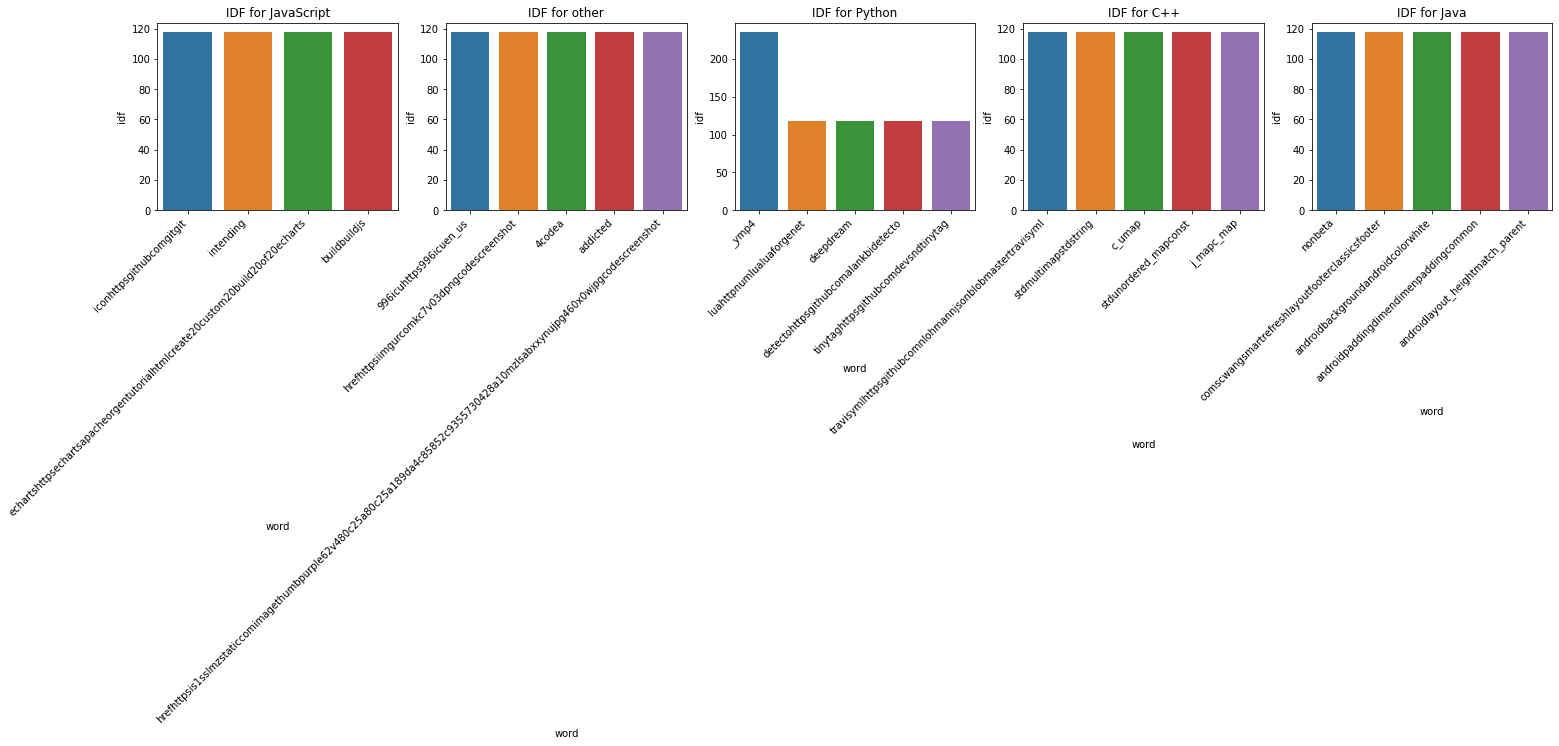

In [34]:
f = plt.figure(figsize=(25,20))
languages = df.is_top_language.unique()
for count, language in enumerate(languages):

    f.add_subplot(5,5, count+1)
    sns.barplot(data=idf_scores[idf_scores.language == language], x=idf_scores[idf_scores.language == language].index, y="idf")
    plt.title(f"IDF for {language}")
    plt.xticks(rotation = 45, ha="right")

plt.tight_layout()

We can see that there might be some problems with the tokenizer, which is leading to some words not being spaced out, as a result, characters are being clump together to create extra longs words, or words with no meaning. I sugest we perhaps don't use this for modeling.

# Is there a difference in the mean number of words by language?

* $H_0$: There is no significant difference between the mean word count of each language when compared with the mean word count of the group.
* $H_a$: There is a significant difference between the mean word count of each language when compared with the mean word count of the group.

$\alpha$ = 0.05

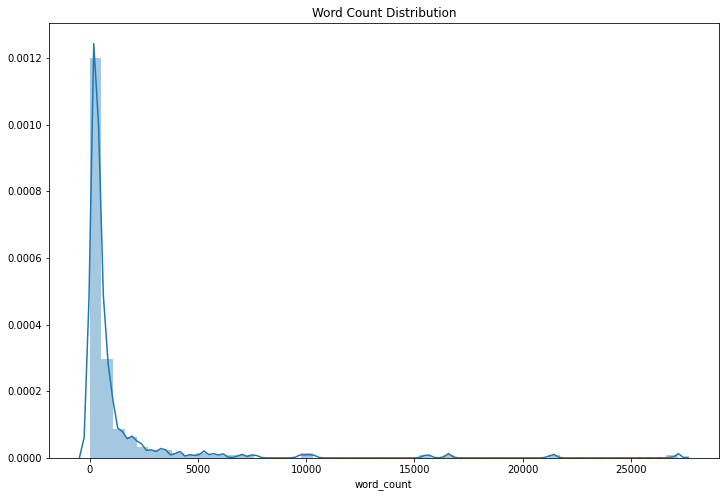

In [35]:
explore.plot_word_count_distribution(df)

It is clear that the word count is not normally distributed. The count is actually right skewed, meaning that most of the word counts by readme are below the average. There seems that there are several outliers that are skewing the data. As such, we likely won't be able to do an accurate t-test, as that requires that the data is normally distributed. 

In [36]:
mean_word_count = df.groupby("is_top_language").word_count.mean()
mean_word_count

is_top_language
C++            724.823529
Java           416.181818
JavaScript    1058.542373
Python        1884.892857
other         1280.227273
Name: word_count, dtype: float64

In [37]:
languages = df.is_top_language.unique()
for language in languages:
    subgroup = df[df.is_top_language == language].word_count
    tsat, p = stats.ttest_1samp(subgroup, df.word_count.mean())
    print(f" The p value for {language} is {p:.2f}")

 The p value for JavaScript is 0.69
 The p value for other is 0.77
 The p value for Python is 0.15
 The p value for C++ is 0.22
 The p value for Java is 0.00


As we can see, the only language that has a word count that is significantly different is `C++`. We can see that, on average, `C++` does have a smaller number of word per readme than the rest. However, given that the data is not normally distributed, we can't trust the results too much.

### Sentiment Analysis

In [38]:
df

,repo,language,readme_contents,clean_tokes,clean_lemmatized,is_top_language,word_count
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,"[freecodecamporg, social, bannerhttpss3amazona...",freecodecamporg social bannerhttpss3amazonawsc...,JavaScript,635
1,996icu/996.ICU,Rust,[996.ICU](https://996.icu/#/en_US)\n=======\n*...,"[996icuhttps996icuen_us, please, note, that, t...",996icuhttps996icuen_us please note exists offi...,other,467
4,facebook/react,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...,"[reacthttpsreactjsorg, middot, github, license...",reacthttpsreactjsorg middot github licensehttp...,JavaScript,324
16,airbnb/javascript,JavaScript,# Airbnb JavaScript Style Guide() {\n\n*A most...,"[airbnb, javascript, style, guide, a, mostly, ...",airbnb javascript style guide mostly reasonabl...,JavaScript,7587
17,flutter/flutter,Dart,# [![Flutter logo][]][flutter.dev]\n\n[![Build...,"[flutter, logoflutterdev, build, status, cirru...",flutter logoflutterdev build status cirrusbuil...,other,309
...,...,...,...,...,...,...,...
376,nlohmann/json,C++,[![JSON for Modern C++](https://raw.githubuser...,"[json, for, modern, chttpsrawgithubusercontent...",json modern chttpsrawgithubusercontentcomnlohm...,C++,6141
377,inconshreveable/ngrok,Go,[![Build\nstatus](https://travis-ci.org/incons...,"[build, statushttpstravisciorginconshreveablen...",build statushttpstravisciorginconshreveablengr...,other,237
378,jinzhu/gorm,Go,# GORM\n\nThe fantastic ORM library for Golang...,"[gorm, the, fantastic, orm, library, for, gola...",gorm fantastic orm library golang aim develope...,other,96
379,NativeScript/NativeScript,TypeScript,# NativeScript [![Build Status](https://travis...,"[nativescript, build, statushttpstravisciorgna...",nativescript build statushttpstravisciorgnativ...,other,372


In [39]:
sia = nltk.sentiment.SentimentIntensityAnalyzer()
df["sentiment"] = df.clean_lemmatized.apply(lambda blog: sia.polarity_scores(blog)["compound"])

Text(0.5, 1.0, "Sentiment Analysis of all README's")

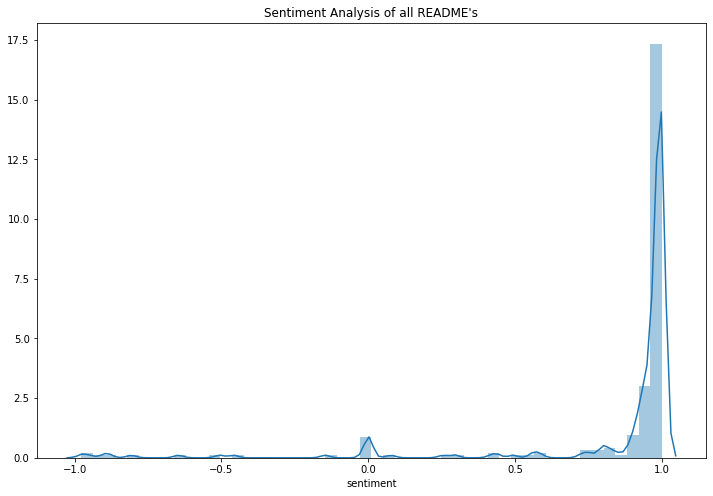

In [40]:
plt.figure(figsize=(12, 8))
sns.distplot(df.sentiment)
plt.title("Sentiment Analysis of all README's")

Interestingly, it seems that there is an abundance of positive sentiment in the majority of the README's. Initially, we suspected that the majority would likely be `neutral`, as a lot of the coding vernacular is usually descriptive, rather than emotive. We also expected a larger number of negative README's, given that many will state a problem or a frustration, and this would likely be picked up as a negative sentiment. 

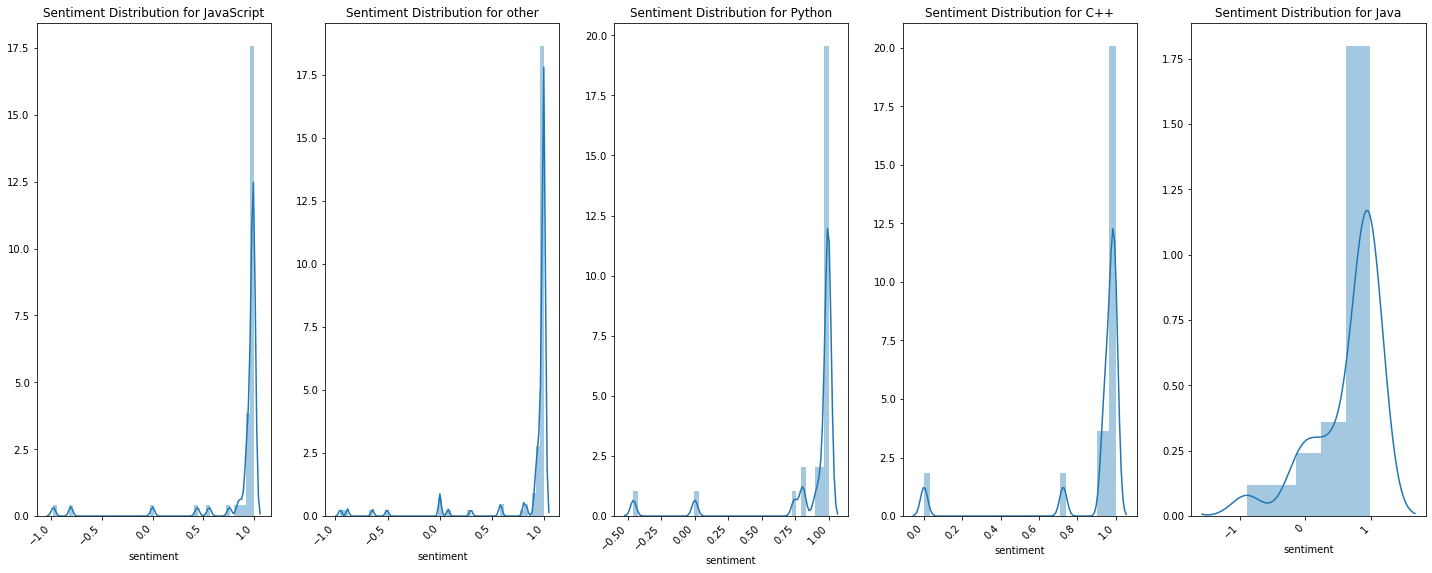

In [41]:
# How does sentiment look across the different languages?

f = plt.figure(figsize=(20,8))
languages = df.is_top_language.unique()

for count, language in enumerate(languages):

    f.add_subplot(1,5, count+1)
    sns.distplot(df[df.is_top_language == language].sentiment)
    plt.title(f"Sentiment Distribution for {language}")
    plt.xticks(rotation = 45, ha="right")

plt.tight_layout()



As we can see, most languages are actually similar in terms of their overall sentiment, with the majority of README's having a very positive sentiment. 

Some key-takeaways:

* `C++` seems to be the most positive lanuage, given that is has no README's with a sentiment score below zero. This means that most README's are either very positive, or a worst, neautral, but not negative. 
* `Java` seems to have the most normally distributed sentiment. While still left skewed, there are more cases across the spectrum. This is likely because it is a smaller number of cases.

In [42]:
# def most_frequent_bigram(s: pd.Series) -> str:
#     # your code might be more or less complicated here, depending on how much
#     # text prep you've already done or more you want to do in this function
#     words = clean(' '.join(s))
#     most_common_bigram = pd.Series(nltk.bigrams(words)).value_counts().head(1).index
#     return most_common_bigram

# def clean(text: str, ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']) -> list:
#         'A simple function to cleanup text data'
#         wnl = nltk.stem.WordNetLemmatizer()
#         stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
#         text = (text.encode('ascii', 'ignore')
#                 .decode('utf-8', 'ignore')
#                 .lower())
#         words = re.sub(r'[^\w\s]', '', text).split() # tokenization
#         return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [43]:
# What are the most frequent bigrams in positive README's?

positive = df[df.sentiment > .8]
positive.groupby("is_top_language").readme_contents.agg(explore.most_frequent_bigram)

is_top_language
C++                 (window, terminal)
Java                    (spring, boot)
JavaScript    (freewarefreeware, icon)
Python                  (yes, unknown)
other                 (summary, added)
Name: readme_contents, dtype: object

In [44]:
# What are the most frequent bigrams in negative README's?

positive = df[df.sentiment < -.8]
positive.groupby("is_top_language").readme_contents.agg(explore.most_frequent_bigram)

is_top_language
Java               (header, footer)
JavaScript                 (de, la)
other         (install, shellcheck)
Name: readme_contents, dtype: object

Given the large size of the majority of README's - I suspect that the sentiment analysis is probably not going to be very effective. We may try with a different sentiment analyser to see if we can get more accurate results. Unfortunately, given the information at the moment, it seems that sentiment analysis would not be a specially good feature for modeling.

# Modeling

In [45]:
import model

from sklearn.feature_extraction.text import CountVectorizer 

from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [46]:
X_train, X_validate, X_test, y_train, y_validate, y_test = model.preprocessing(df, "tf_idf", "is_top_language")
predictions = pd.DataFrame({"actual": y_train, "baseline": y_train.mode()[0]})

### Decision Tree

In [47]:
data_rep = ["bag_of_words", "tf_idf", "bag_of_ngrams"]

for i in data_rep:
    if i == "bag_of_ngrams":
        X_train, X_validate, X_test, y_train, y_validate, y_test = model.preprocessing(df, "bag_of_ngrams", "is_top_language", ngram_range = (1,2))
        clf, y_pred = model.run_clf(X_train, y_train, 5)
        score = clf.score(X_train, y_train)
        print(f"{i}, score = {score}")
    else: 
        
        X_train, X_validate, X_test, y_train, y_validate, y_test = model.preprocessing(df, i, "is_top_language")
        clf, y_pred = model.run_clf(X_train, y_train, 5)
        score = clf.score(X_train, y_train)
        print(f"{i}, score = {score}")
    

bag_of_words, score = 0.864406779661017
tf_idf, score = 0.847457627118644
bag_of_ngrams, score = 0.864406779661017


In [48]:
X_train, X_validate, X_test, y_train, y_validate, y_test = model.preprocessing(df, "tf_idf", "is_top_language")
for i in range(1, 20):
    clf, y_pred = model.run_clf(X_train, y_train, i)
    score = clf.score(X_train, y_train)
    validate_score = clf.score(X_validate, y_validate)
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. Diff = {(score - validate_score) / score:.2f}")

Max_depth = 1, accuracy_score = 0.56. Diff = 0.13
Max_depth = 2, accuracy_score = 0.64. Diff = 0.15
Max_depth = 3, accuracy_score = 0.69. Diff = 0.24
Max_depth = 4, accuracy_score = 0.79. Diff = 0.24
Max_depth = 5, accuracy_score = 0.85. Diff = 0.30
Max_depth = 6, accuracy_score = 0.90. Diff = 0.32
Max_depth = 7, accuracy_score = 0.94. Diff = 0.35
Max_depth = 8, accuracy_score = 0.97. Diff = 0.39
Max_depth = 9, accuracy_score = 0.97. Diff = 0.37
Max_depth = 10, accuracy_score = 0.98. Diff = 0.39
Max_depth = 11, accuracy_score = 0.98. Diff = 0.45
Max_depth = 12, accuracy_score = 0.99. Diff = 0.42
Max_depth = 13, accuracy_score = 0.99. Diff = 0.39
Max_depth = 14, accuracy_score = 1.00. Diff = 0.47
Max_depth = 15, accuracy_score = 1.00. Diff = 0.47
Max_depth = 16, accuracy_score = 1.00. Diff = 0.47
Max_depth = 17, accuracy_score = 1.00. Diff = 0.47
Max_depth = 18, accuracy_score = 1.00. Diff = 0.47
Max_depth = 19, accuracy_score = 1.00. Diff = 0.47


In [49]:
X_train, X_validate, X_test, y_train, y_validate, y_test = model.preprocessing(df, "tf_idf", "is_top_language")
clf, y_pred = model.run_clf(X_train, y_train, 5)
predictions["decision_tree"] = y_pred

In [50]:
accuracy_score, matrix, report = model.accuracy_report(clf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.85
            C++  Java  JavaScript  Python  other
C++           4     0           0       0      7
Java          0    10           0       0      4
JavaScript    0     0          45       0      3
Python        0     0           0      15      9
other         0     0           3       1     76


,C++,Java,JavaScript,Python,other,accuracy,macro avg,weighted avg
precision,1.000000,1.000000,0.9375,0.9375,0.767677,0.847458,0.928535,0.869571
recall,0.363636,0.714286,0.9375,0.6250,0.950000,0.847458,0.718084,0.847458
f1-score,0.533333,0.833333,0.9375,0.7500,0.849162,0.847458,0.780666,0.838793
support,11.000000,14.000000,48.0000,24.0000,80.000000,0.847458,177.000000,177.000000


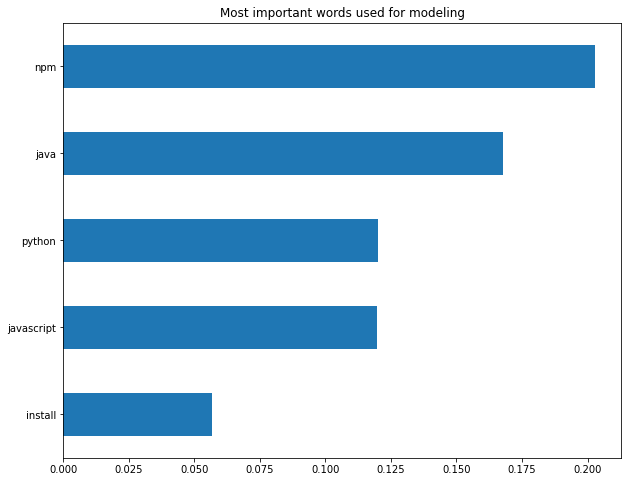

In [51]:
model.preprocessing_features(clf)

### Random Forest

In [52]:
data_rep = ["bag_of_words", "tf_idf", "bag_of_ngrams"]

for i in data_rep:
    X_train, X_validate, X_test, y_train, y_validate, y_test = model.preprocessing(df, i, "is_top_language")
    rf = RandomForestClassifier(random_state= 123, min_samples_leaf = 1, max_depth = 5).fit(X_train, y_train)
    score = rf.score(X_train, y_train)
    print(f"{i}, score = {score}")
    

bag_of_words, score = 0.5649717514124294
tf_idf, score = 0.6497175141242938
bag_of_ngrams, score = 0.4689265536723164


We can see that the best alternative is to use tf_idf for this model

In [53]:
X_train, X_validate, X_test, y_train, y_validate, y_test = model.preprocessing(df, "tf_idf", "is_top_language")

In [54]:
for i in range(1, 20):
    rf, y_pred = model.run_rf(X_train, y_train, 1, i)
    score = rf.score(X_train, y_train)
    validate_score = rf.score(X_validate, y_validate)
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. Diff = {(score - validate_score) / score:.2f}")

Max_depth = 1, accuracy_score = 0.45. Diff = -0.12
Max_depth = 2, accuracy_score = 0.46. Diff = -0.11
Max_depth = 3, accuracy_score = 0.48. Diff = -0.06
Max_depth = 4, accuracy_score = 0.54. Diff = 0.06
Max_depth = 5, accuracy_score = 0.65. Diff = 0.22
Max_depth = 6, accuracy_score = 0.71. Diff = 0.26
Max_depth = 7, accuracy_score = 0.76. Diff = 0.31
Max_depth = 8, accuracy_score = 0.77. Diff = 0.32
Max_depth = 9, accuracy_score = 0.81. Diff = 0.35
Max_depth = 10, accuracy_score = 0.83. Diff = 0.39
Max_depth = 11, accuracy_score = 0.86. Diff = 0.41
Max_depth = 12, accuracy_score = 0.86. Diff = 0.41
Max_depth = 13, accuracy_score = 0.88. Diff = 0.44
Max_depth = 14, accuracy_score = 0.89. Diff = 0.43
Max_depth = 15, accuracy_score = 0.93. Diff = 0.45
Max_depth = 16, accuracy_score = 0.94. Diff = 0.48
Max_depth = 17, accuracy_score = 0.95. Diff = 0.47
Max_depth = 18, accuracy_score = 0.98. Diff = 0.50
Max_depth = 19, accuracy_score = 0.98. Diff = 0.48


The best score, that doesn't overfit, is a max_depth of 2

In [55]:
rf, y_pred = model.run_rf(X_train, y_train, 1, 2)
predictions["random_forest"] = y_pred

In [56]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.46
            C++  Java  JavaScript  Python  other
C++           0     0           0       0     11
Java          0     0           0       0     14
JavaScript    0     0           1       0     47
Python        0     0           0       0     24
other         0     0           0       0     80


,C++,Java,JavaScript,Python,other,accuracy,macro avg,weighted avg
precision,0.0,0.0,1.000000,0.0,0.454545,0.457627,0.290909,0.476631
recall,0.0,0.0,0.020833,0.0,1.000000,0.457627,0.204167,0.457627
f1-score,0.0,0.0,0.040816,0.0,0.625000,0.457627,0.133163,0.293555
support,11.0,14.0,48.000000,24.0,80.000000,0.457627,177.000000,177.000000


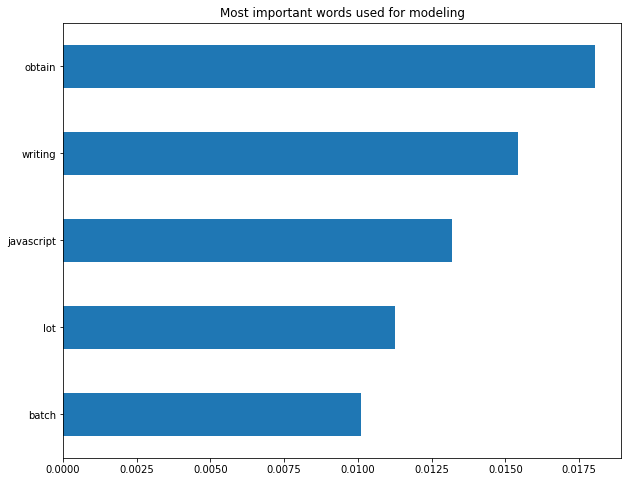

In [57]:
model.preprocessing_features(rf)

### KNN

In [58]:
data_rep = ["bag_of_words", "tf_idf", "bag_of_ngrams"]

for i in data_rep:
    X_train, X_validate, X_test, y_train, y_validate, y_test = model.preprocessing(df, i, "is_top_language")
    knn, y_pred = model.run_knn(X_train, y_train, 5)
    score = knn.score(X_train, y_train)
    print(f"{i}, score = {score}")
    

bag_of_words, score = 0.615819209039548
tf_idf, score = 0.7288135593220338
bag_of_ngrams, score = 0.3728813559322034


In [59]:
for i in range(1, 20):
    knn, y_pred = model.run_knn(X_train, y_train, i)
    score = knn.score(X_train, y_train)
    validate_score = knn.score(X_validate, y_validate)
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. Diff = {(score - validate_score) / score:.2f}")

Max_depth = 1, accuracy_score = 0.99. Diff = 0.91
Max_depth = 2, accuracy_score = 0.54. Diff = 0.62
Max_depth = 3, accuracy_score = 0.55. Diff = 0.78
Max_depth = 4, accuracy_score = 0.47. Diff = 0.57
Max_depth = 5, accuracy_score = 0.37. Diff = 0.41
Max_depth = 6, accuracy_score = 0.37. Diff = 0.45
Max_depth = 7, accuracy_score = 0.78. Diff = 0.37
Max_depth = 8, accuracy_score = 0.75. Diff = 0.32
Max_depth = 9, accuracy_score = 0.71. Diff = 0.28
Max_depth = 10, accuracy_score = 0.50. Diff = -0.04
Max_depth = 11, accuracy_score = 0.46. Diff = -0.11
Max_depth = 12, accuracy_score = 0.46. Diff = -0.11
Max_depth = 13, accuracy_score = 0.46. Diff = -0.11
Max_depth = 14, accuracy_score = 0.46. Diff = -0.11
Max_depth = 15, accuracy_score = 0.45. Diff = -0.12
Max_depth = 16, accuracy_score = 0.45. Diff = -0.12
Max_depth = 17, accuracy_score = 0.45. Diff = -0.12
Max_depth = 18, accuracy_score = 0.45. Diff = -0.12
Max_depth = 19, accuracy_score = 0.45. Diff = -0.12


In [60]:
knn, y_pred = model.run_knn(X_train, y_train, 2)
predictions["knn"] = y_pred

In [61]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.54
            C++  Java  JavaScript  Python  other
C++          11     0           0       0      0
Java          0    14           0       0      0
JavaScript    0     0          48       0      0
Python        1     0           1      22      0
other         1     0           0      78      1


,C++,Java,JavaScript,Python,other,accuracy,macro avg,weighted avg
precision,0.846154,1.0,0.979592,0.220000,1.000000,0.542373,0.809149,0.879142
recall,1.000000,1.0,1.000000,0.916667,0.012500,0.542373,0.785833,0.542373
f1-score,0.916667,1.0,0.989691,0.354839,0.024691,0.542373,0.657177,0.463728
support,11.000000,14.0,48.000000,24.000000,80.000000,0.542373,177.000000,177.000000


In [62]:
report = model.create_report(predictions.actual, predictions.decision_tree)

In [63]:
# How do the different models compare on accuracy?
print("Accuracy Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report.accuracy[0]:.2f}')

Accuracy Scores
---------------
Actual = 1.00
Baseline = 0.45
Decision_Tree = 0.85
Random_Forest = 0.46
Knn = 0.54


Key take-aways:
* All models perform better than the baseline, which means implementation of machine learning algorithms for this particular project is an improvement.
* The best performing model is the `Decision Tree` classifier, with an accuracy of 80%
* Given that there is no way to quantify cost, and in this particular case neither recall nor precision are more or less important, we will focus on the general accuracy of the models (given that both metrics are used to calcualte accuracy).

# Evaluation

In [64]:
# Now we will see if the model is overfit

X_train, X_validate, X_test, y_train, y_validate, y_test = model.preprocessing(df, "tf_idf", "is_top_language")
clf, y_pred = model.run_clf(X_train, y_train, 6)

In [65]:
clf.score(X_test, y_test)

0.6101694915254238

### Build a function that will take in a text of a README file, and tries to predict the programming language

In [66]:
def predict_readme_language(readme):
    df = model.acquire_data()
    df = model.prepare_data(df)

    tfidf = TfidfVectorizer()
    X = tfidf.fit_transform(df.readme_contents.apply(clean).apply(' '.join)) 
    y = df["is_top_language"]

    X_train, X_validate, X_test, y_train, y_validate, y_test = model.split_data(X, y)
    
    clf, y_pred = model.run_clf(X_train, y_train, 5)
    
    text = prepare.prepare_data(readme)
    
    X = tfidf.transform(text.readme_contents.apply(clean).apply(' '.join))
    
    prediction = clf.predict(X)
    
    return prediction

In [67]:
text = df.tail(5).head(1)

In [68]:
text

,repo,language,readme_contents,clean_tokes,clean_lemmatized,is_top_language,word_count,sentiment
376,nlohmann/json,C++,[![JSON for Modern C++](https://raw.githubuser...,"[json, for, modern, chttpsrawgithubusercontent...",json modern chttpsrawgithubusercontentcomnlohm...,C++,6141,0.9999


In [69]:
# Now we can test the function

prediction = model.predict_readme_language(text)
print(f"This language was likely written in {prediction[0]}")

This language was likely written in other


# Conclusion